In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader
import torchvision.transforms as tt

In [2]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(BATCH_SIZE, -1)
    
class Conv_Net(nn.Module):
    def __init__(self, seq, clf):
        super(Conv_Net, self).__init__()
        self.seq = seq
        self.clf = clf
        
    def forward(self, x):
        return self.clf(self.seq(x)) 

def build_new_net():
    #architecture of the network copied from the article
    seq = nn.Sequential(
        nn.Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1)),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1)),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1, ceil_mode=False),
        Flatten()
    )
    clf = nn.Linear(in_features=4608, out_features=10, bias=True)
    return seq, clf

In [3]:
#copied numbers from the article
N_EPOCHS = 280
Z_DIM = 2
STAT_STEP = 10
BATCH_SIZE = 32

device = 'cpu'

In [4]:
#read data
PATH = './models_notMNIST/model_'
weights_paths = []
learned_models = []
for i in range(100):
    #reaally not effective
    seq, clf = build_new_net()
    model = Conv_Net(seq, clf)
    weights_paths.append(PATH + str(i) + '.pt')
    
    model.load_state_dict(torch.load(weights_paths[i], map_location = 'cpu'))
    learned_models.append(model)

In [5]:
weights = []
for model in learned_models:
    weights.append(model.seq)
    
print(weights[0])

Sequential(
  (0): Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
)


In [6]:
weights[0][0].weight.size()
for i in range(len(weights)):
    weights[i] = weights[i][0].weight

In [7]:
import matplotlib.pyplot as plt

plt.imshow(weights[99][10].detach().numpy().reshape((7, 7)))

In [8]:
train_loader = DataLoader(dataset=weights, batch_size=BATCH_SIZE, shuffle=True) 

In [9]:
#cuda!
#test on colab at least one iteration
class VAE(nn.Module):
    def __init__(self, D, d = Z_DIM):
        super(VAE, self).__init__()
        self.encoder = Encoder(d, D)
        self.decoder = Decoder(d, D)
        
        #d - for latent space
        self.d = d
        self.D = D
        
    def count_vlb(self, X, i):
        #get parameters of z distribution
        mu_z, var_z = self.encoder(X)

        #sample latent(mu_z, var_z)
        z = Normal(torch.zeros(mu_z.size()), torch.ones(mu_z.size())).sample()
        z = mu_z + torch.sqrt(var_z) * nn.Parameter(z, requires_grad=False)
              
        #get parameters of x_hat distribution
        mu_x, var_x = self.decoder(z)
                
        normal = Normal(mu_x, torch.sqrt(var_x))
        diagn = torch.distributions.Independent(normal, 1)
         
        #count loss
        latent_loss = 0.5 * torch.sum(var_x + mu_x**2 - torch.log(var_x+1e-12) - 1)
        reconstruction_loss = diagn.log_prob(X)
        
        #coefs are to be chosen
        return -(torch.sum(reconstruction_loss) - latent_loss), latent_loss, torch.sum(reconstruction_loss)
                   
    def generate_samples(self, num_samples):
        z = torch.FloatTensor(np.random.normal(0, 1, size=[num_samples, self.d, 1, 1]))
        return self.decoder(z)

In [10]:
class Encoder(nn.Module):
    def __init__(self, d, D):
        super(Encoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        
        self.fc_mu = nn.Conv2d(64, Z_DIM, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [11]:
class Decoder(nn.Module):
    def __init__(self, d, D):
        super(Decoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        self.fc_mu = nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [12]:
#Adam optimizer with linear learning rate decay from 1e-3 to 0.
vae = VAE(49)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2)

In [13]:
loss_list = []
kl_loss_list = []
l2_loss_list = []
N_STEPS = len(train_loader)
print(N_STEPS)

#train network
for j in range(N_EPOCHS):
    for k, images in enumerate(train_loader):
        #forward
        images = images.view(images.size()[0]*images.size()[1], 1, 7, -1)
        images = images.to(device)
        vlb, kl, l2 = vae.count_vlb(images, j*N_EPOCHS + k)

        #backward
        optimizer.zero_grad()
        vlb.backward()
        optimizer.step()
        
        if j % 50 == 0:
            optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2*(1 - j/N_EPOCHS))

        loss_list.append(vlb.item())
        kl_loss_list.append(kl)
        l2_loss_list.append(l2)
        
        if k % STAT_STEP == 0 and j % 10 == 0:
            print('Epoch {}/{}, Step {}/{}, Loss: {}'
                  .format(j, N_EPOCHS, k, N_STEPS, vlb.item()))

4
Epoch 0/280, Step 0/4, Loss: 312697.09375
Epoch 10/280, Step 0/4, Loss: 217937.4375
Epoch 20/280, Step 0/4, Loss: 200312.28125
Epoch 30/280, Step 0/4, Loss: 194773.375
Epoch 40/280, Step 0/4, Loss: 191277.765625
Epoch 50/280, Step 0/4, Loss: 192764.5625
Epoch 60/280, Step 0/4, Loss: 190384.234375
Epoch 70/280, Step 0/4, Loss: 190619.65625
Epoch 80/280, Step 0/4, Loss: 189891.46875
Epoch 90/280, Step 0/4, Loss: 189914.421875
Epoch 100/280, Step 0/4, Loss: 189684.140625
Epoch 110/280, Step 0/4, Loss: 189095.625
Epoch 120/280, Step 0/4, Loss: 189372.625
Epoch 130/280, Step 0/4, Loss: 189089.515625
Epoch 140/280, Step 0/4, Loss: 189601.0
Epoch 150/280, Step 0/4, Loss: 189273.90625
Epoch 160/280, Step 0/4, Loss: 188628.375
Epoch 170/280, Step 0/4, Loss: 190330.609375
Epoch 180/280, Step 0/4, Loss: 188461.671875
Epoch 190/280, Step 0/4, Loss: 189450.078125
Epoch 200/280, Step 0/4, Loss: 188419.671875
Epoch 210/280, Step 0/4, Loss: 187864.390625
Epoch 220/280, Step 0/4, Loss: 188105.5625
Ep

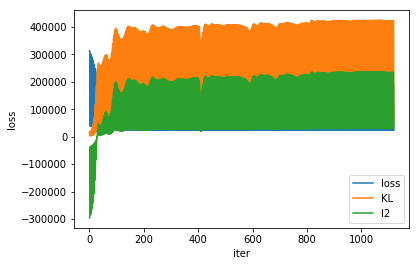

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([i for i in range(len(loss_list))], loss_list, label = 'loss')
plt.plot([i for i in range(len(loss_list))], kl_loss_list, label = 'KL')
plt.plot([i for i in range(len(loss_list))], l2_loss_list, label = 'l2')

plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()

plt.show()

In [15]:
torch.save(vae.state_dict(), "vae_weights.pth")

[10.41625  14.148709 10.365231 ... 10.655014  9.808436 10.904592]


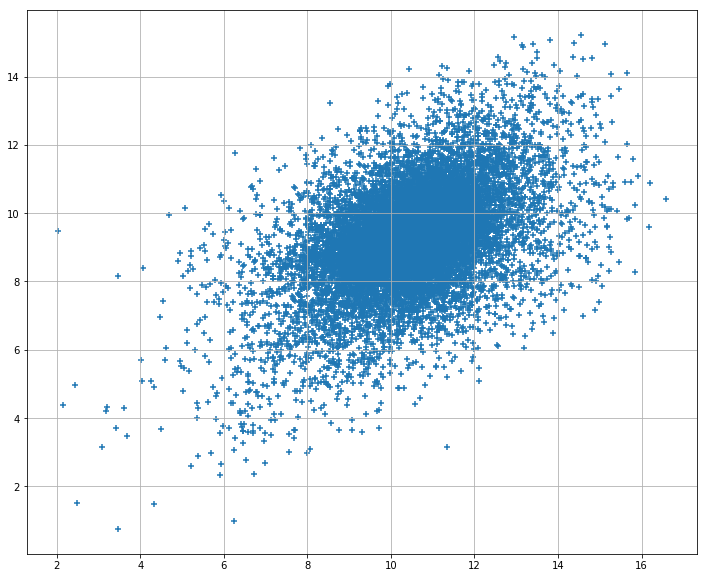

In [16]:
vae.load_state_dict(torch.load("vae_weights.pth"))

mu_list = []

with torch.no_grad():
    for k, images in enumerate(train_loader):
        images = images.view(images.size()[0]*images.size()[1], 1, 7, -1)
        images = images.to(device)
        
        mu, var  = vae.encoder(images)
        mu = mu.cpu().numpy()
        mu_list.append(mu)

mu = np.concatenate(mu_list)
mu = np.squeeze(mu, axis = 2)
mu = np.squeeze(mu, axis = 2)

print(mu[:, 0])

plt.figure(figsize=(12, 10))

plt.scatter(mu[:, 0], mu[:, 1], marker = '+')

plt.grid()
    

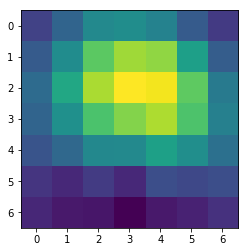

In [17]:
with torch.no_grad():
    mu_x, _ = vae.generate_samples(100)
    mu_x = mu_x.detach().cpu().numpy()
    
plt.imshow(mu_x[50].reshape((7, 7)))

In [18]:
mu = torch.eye(3, 3)*10
mu[0, 1] = 2
mu[0, 2] = 10
mu[1, 0] = 3
mu[1, 2] = -1
mu[2, 0] = 1
mu[2, 1] = -10
mu = mu
print(mu)
sigma = torch.eye(3, 3)*2
sigma[0, 1] = 2
sigma[0, 2] = 10
sigma[1, 0] = 3
sigma[1, 2] = 100
sigma[2, 0] = 1
sigma[2, 1] = 10
print(sigma)
K = 1

tensor([[ 10.,   2.,  10.],
        [  3.,  10.,  -1.],
        [  1., -10.,  10.]])
tensor([[   2.,    2.,   10.],
        [   3.,    2.,  100.],
        [   1.,   10.,    2.]])
